In [1]:
from collections import deque
import datetime

import numpy as np

from qstrader import settings
from qstrader.strategy.base import AbstractStrategy
from qstrader.event import SignalEvent, EventType
from qstrader.compat import queue
from qstrader.trading_session import TradingSession

In [2]:
class MovingAverageCrossStrategy(AbstractStrategy):
    """
    Requires:
    ticker - The ticker symbol being used for moving averages
    events_queue - A handle to the system events queue
    short_window - Lookback period for short moving average
    long_window - Lookback period for long moving average
    """
    def __init__(
        self, ticker,
        events_queue,
        short_window=100,
        long_window=300,
        base_quantity=100
    ):
        self.ticker = ticker
        self.events_queue = events_queue
        self.short_window = short_window
        self.long_window = long_window
        self.base_quantity = base_quantity
        self.bars = 0
        self.invested = False
        self.sw_bars = deque(maxlen=self.short_window)
        self.lw_bars = deque(maxlen=self.long_window)

    def calculate_signals(self, event):
        if (
            event.type == EventType.BAR and
            event.ticker == self.ticker
        ):
            # Add latest adjusted closing price to the
            # short and long window bars
            self.lw_bars.append(event.adj_close_price)
            if self.bars > self.long_window - self.short_window:
                self.sw_bars.append(event.adj_close_price)

            # Enough bars are present for trading
            if self.bars > self.long_window:
                # Calculate the simple moving averages
                short_sma = np.mean(self.sw_bars)
                long_sma = np.mean(self.lw_bars)
                # Trading signals based on moving average cross
                if short_sma > long_sma and not self.invested:
                    print("LONG %s: %s" % (self.ticker, event.time))
                    signal = SignalEvent(
                        self.ticker, "BOT",
                        suggested_quantity=self.base_quantity
                    )
                    self.events_queue.put(signal)
                    self.invested = True
                elif short_sma < long_sma and self.invested:
                    print("SHORT %s: %s" % (self.ticker, event.time))
                    signal = SignalEvent(
                        self.ticker, "SLD",
                        suggested_quantity=self.base_quantity
                    )
                    self.events_queue.put(signal)
                    self.invested = False
            self.bars += 1


In [3]:
def run(config, testing, tickers, filename):
    # Backtest information
    title = ['Moving Average Crossover Example on AAPL: 100x300']
    initial_equity = 10000.0
    start_date = datetime.datetime(2000, 1, 1)
    end_date = datetime.datetime(2014, 1, 1)

    # Use the MAC Strategy
    events_queue = queue.Queue()
    strategy = MovingAverageCrossStrategy(
        tickers[0], events_queue,
        short_window=100,
        long_window=300
    )

    # Set up the backtest
    backtest = TradingSession(
        config, strategy, tickers,
        initial_equity, start_date, end_date,
        events_queue, title=title,
        benchmark=tickers[1],
    )
    results = backtest.start_trading(testing=testing)
    return results


/Users/sujogale/qstrader/qstraderp3/lib/python3.6/site-packages/qstrader/settings.py:46: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  conf = yaml.load(fd)


Running Backtest...
LONG AAPL: 2002-02-08 00:00:00
SHORT AAPL: 2002-08-14 00:00:00
LONG AAPL: 2003-07-15 00:00:00
SHORT AAPL: 2008-10-17 00:00:00
LONG AAPL: 2009-07-28 00:00:00
SHORT AAPL: 2013-02-19 00:00:00
LONG AAPL: 2013-11-29 00:00:00
---------------------------------
Backtest complete.
Sharpe Ratio: 0.64
Max Drawdown: 40.94%


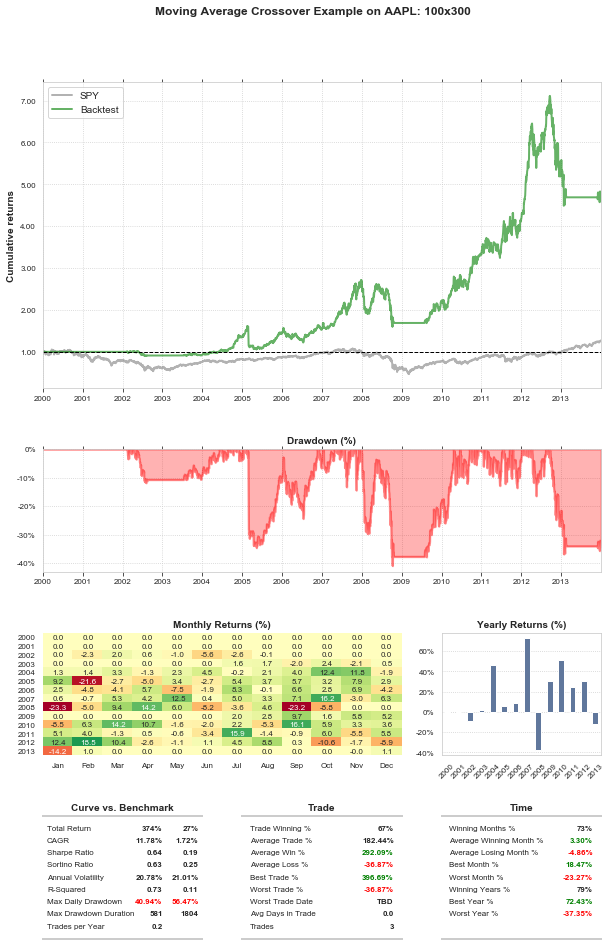

In [5]:
testing = False
config = settings.from_file(
    settings.DEFAULT_CONFIG_FILENAME, testing)
tickers = ["AAPL", "SPY"]
filename = None
opt = run(config, testing, tickers, filename);
